# Exploration & test - Oph

In [3]:
!pip install tensorflow

  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached op

In [5]:
!pip install tqdm

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 606.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 2.2 MB/s eta 0:00:00


In [2]:
import cv2 as cv
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt
import json
import tqdm
from IPython.display import clear_output
from collections import Counter

%matplotlib inline

2.16.1


Détails des données input: 
- leftmg8bits = images originales (utilisées comme input X)
- gtFine_labelIds = images annotées en niveaux de gris = masques où chaque pixel est mappé à son ID de classe (utilisées comme y)
- gtFine_color = images annotées en couleur = masques d'annotations où chaque classe est représentée par une couleur (utilisées à des fins de visu, pas utilisées comme input)

Output : masque de segmentation où chaque pixel est classé dans sa catégorie. Même dimension que l'image d'entrée, avec 8 canaux pour les prédictions brutes, et 1 canal pour les prédictions argmax (1 pixel = 1 classe ayant la plus forte probabilité).

In [11]:
from collections import namedtuple

In [12]:
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [12]:
Label.category

_tuplegetter(3, 'Alias for field number 3')

In [13]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [27]:
type(labels)

list

In [31]:
# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
id2category     = { label[4]   : label.category for label in labels  }
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

In [34]:
trainId2label

{-1: Label(name='license plate', id=-1, trainId=-1, category='vehicle', categoryId=7, hasInstances=False, ignoreInEval=True, color=(0, 0, 142)),
 18: Label(name='bicycle', id=33, trainId=18, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(119, 11, 32)),
 17: Label(name='motorcycle', id=32, trainId=17, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 0, 230)),
 16: Label(name='train', id=31, trainId=16, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 80, 100)),
 255: Label(name='unlabeled', id=0, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 15: Label(name='bus', id=28, trainId=15, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 60, 100)),
 14: Label(name='truck', id=27, trainId=14, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 0, 70)),
 13: Label(name='car', id

In [19]:
id2category

{0: 'void',
 1: 'flat',
 2: 'construction',
 3: 'object',
 4: 'nature',
 5: 'sky',
 6: 'human',
 7: 'vehicle'}

In [11]:
def get_numpy_mask_from_image(mask_img):
    mask_array   = np.zeros((mask_img.shape[0], mask_img.shape[1], 8),dtype=int) # create a mask with zeros

    for k, v in category2labels.items():
        #print("[INFO] : Processing for main category ", k)
        for category_label in v: 
            categoryId = category_label[4]
            labelID = category_label[1]
            #print("    [INFO] : Processing for subcategory {} (labelID = {} | categoryId={})".format(category_label[0], labelID, categoryId))
            mask_array[:,:,categoryId] = np.logical_or(mask_array[:,:,categoryId],(mask_img==labelID))
    
    return mask_array

In [60]:
path = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_train_mask_stuttgart/stuttgart_000000_000019_gtFine_labelIds.png"

In [50]:
path = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_train_mask_stuttgart/stuttgart_000000_000019_gtFine_color.png"

In [61]:
image = Image.open(path)

In [62]:
image.mode

'L'

In [67]:
image.size

(2048, 1024)

In [53]:
if image.mode != 'RGB':
    image = image.convert('RGB')

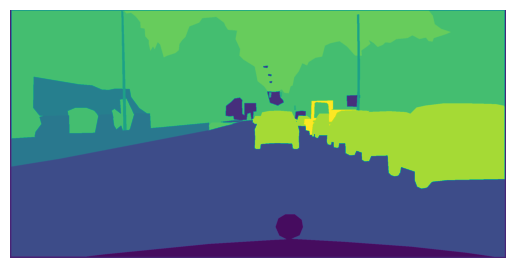

In [63]:
plt.imshow(image)
plt.axis('off')
plt.show()

Tableau numpy de l'image:
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


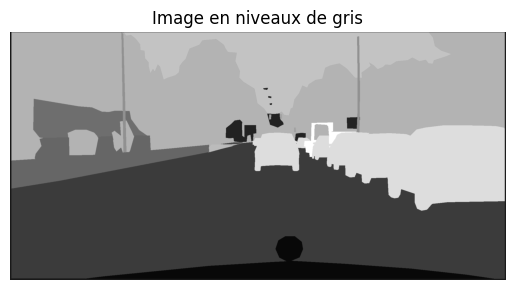

In [64]:
# Convertissez l'image en niveaux de gris
#gray_image = image.convert('L')

# Transformez l'image en un tableau numpy
image_array = np.array(image)

# Affichez le tableau numpy (optionnel)
print("Tableau numpy de l'image:")
print(image_array)

# Affichez l'image pour vérifier visuellement
plt.imshow(image_array, cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')
plt.show()

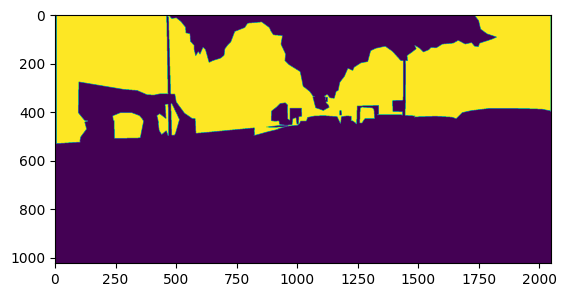

In [65]:
# Get the RGB array of the mask using OpenCV
#mask_array = cv2.cvtColor(cv2.imread(mask_file), cv2.COLOR_BGR2GRAY)

# Get the segmentation matrix
mask = get_numpy_mask_from_image(mask_img = image_array)

# The segmentation is a 8-D matrix, so we cannot display it
# We will just just display the channel ID N°5
# Remember, in id2category, id 5 ==> sky
plt.imshow(mask[:,:,4])
plt.show()

In [13]:
mask

array([[[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       ...,

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [3]:
def load_image(image_path, size=(128, 128)):
    # Ouvrir l'image, redimensionner et normaliser
    image = Image.open(image_path).resize(size)
    return np.array(image) / 255.0  # Normalized RGB image

def load_mask(mask_path, size=(128, 128)):
    # Ouvrir le masque et le redimensionner
    mask = Image.open(mask_path).resize(size)
    return np.array(mask)  # Label IDs (no normalization)

In [4]:
# Exemple d'utilisation avec redimensionnement
train_images = []
train_masks = []
val_images = []
val_masks = []
test_images = []
test_masks = []

# Chemins des répertoires
train_images_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_train_stuttgart"
train_masks_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_train_mask_stuttgart"
val_images_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_val_frankfurt"
val_masks_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_val_mask_frankfurt"
test_images_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_test_berlin"
test_masks_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_test_mask_berlin"

# Chargement des images et des masques pour l'ensemble d'entraînement
for filename in os.listdir(train_images_dir):
    if filename.endswith('_leftImg8bit.png'):
        image_path = os.path.join(train_images_dir, filename)
        mask_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        mask_path = os.path.join(train_masks_dir, mask_filename)

        if os.path.exists(mask_path):
            image = load_image(image_path, size=(128, 128))
            mask = load_mask(mask_path, size=(128, 128))
            
            train_images.append(image)
            train_masks.append(mask)

# Chargement des images et des masques pour l'ensemble de validation
for filename in os.listdir(val_images_dir):
    if filename.endswith('_leftImg8bit.png'):
        image_path = os.path.join(val_images_dir, filename)
        mask_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        mask_path = os.path.join(val_masks_dir, mask_filename)

        if os.path.exists(mask_path):
            image = load_image(image_path, size=(128, 128))
            mask = load_mask(mask_path, size=(128, 128))
            
            val_images.append(image)
            val_masks.append(mask)

# Chargement des images et des masques pour l'ensemble de test
for filename in os.listdir(test_images_dir):
    if filename.endswith('_leftImg8bit.png'):
        image_path = os.path.join(test_images_dir, filename)
        mask_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        mask_path = os.path.join(test_masks_dir, mask_filename)

        if os.path.exists(mask_path):
            image = load_image(image_path, size=(128, 128))
            mask = load_mask(mask_path, size=(128, 128))
            
            test_images.append(image)
            test_masks.append(mask)

# Convertir les listes en tableaux numpy
train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [49]:
train_images.shape

(196, 128, 128, 3)

In [53]:
train_masks.shape

(196, 128, 128)

In [50]:
test_images.shape

(544, 128, 128, 3)

In [51]:
val_images.shape

(267, 128, 128, 3)

Il y a moins d'images dans le dossier train, cela risque d'être problématique ensuite mais pour le moment on continue.

In [7]:
train_masks[0].min()

1

In [8]:
train_masks[0].max()

31

In [6]:
train_masks[0]

array([[ 8, 10, 10, ..., 10, 10,  8],
       [15, 21, 21, ..., 21, 21, 16],
       [15, 21, 21, ..., 21, 21, 16],
       ...,
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 4,  4,  4, ...,  5,  5,  4]], dtype=uint8)

Les masques sont encodés avec les 31 labels. Il faut mapper les labels avec leurs catégories.

In [70]:
def remap_labels_to_categories(mask):
    label_id_to_category_id = {
        0: 0,  # 'void' -> 'void'
        1: 0,  # 'void' -> 'void'
        2: 0,  # 'void' -> 'void'
        3: 0,  # 'void' -> 'void'
        4: 0,  # 'void' -> 'void'
        5: 0,  # 'void' -> 'void'
        6: 0,  # 'void' -> 'void'
        7: 1,  # 'flat' -> 'flat'
        8: 1,  # 'flat' -> 'flat'
        9: 1,  # 'flat' -> 'flat'
        10: 1,  # 'flat' -> 'flat'
        11: 2,  # 'construction' -> 'construction'
        12: 2,  # 'construction' -> 'construction'
        13: 2,  # 'construction' -> 'construction'
        14: 2,  # 'construction' -> 'construction'
        15: 2,  # 'construction' -> 'construction'
        16: 2,  # 'construction' -> 'construction'
        17: 3,  # 'object' -> 'object'
        18: 3,  # 'object' -> 'object'
        19: 3,  # 'object' -> 'object'
        20: 3,  # 'object' -> 'object'
        21: 4,  # 'nature' -> 'nature'
        22: 4,  # 'nature' -> 'nature'
        23: 5,  # 'sky' -> 'sky'
        24: 6,  # 'human' -> 'human'
        25: 6,  # 'human' -> 'human'
        26: 7,  # 'vehicle' -> 'vehicle'
        27: 7,  # 'vehicle' -> 'vehicle'
        28: 7,  # 'vehicle' -> 'vehicle'
        29: 7,  # 'vehicle' -> 'vehicle'
        30: 7,  # 'vehicle' -> 'vehicle'
        31: 7,  # 'vehicle' -> 'vehicle'
        32: 7,  # 'vehicle' -> 'vehicle'
        33: 7,  # 'vehicle' -> 'vehicle'
        -1: 7   # 'vehicle' -> 'vehicle'
    }

    # Exclure les valeurs du masque qui ne sont pas présentes dans le dictionnaire
    mask[mask < 0] = 0
    mask[mask > 33] = 0

    # Remappez chaque valeur du masque à son identifiant de catégorie correspondant
    remapped_mask = np.vectorize(label_id_to_category_id.get)(mask)
    return remapped_mask

# Remappez les masques dans train_masks, val_masks et test_masks
remapped_train_masks = np.array([remap_labels_to_categories(mask) for mask in train_masks])
remapped_val_masks = np.array([remap_labels_to_categories(mask) for mask in val_masks])
remapped_test_masks = np.array([remap_labels_to_categories(mask) for mask in test_masks])

In [71]:
remapped_train_masks[0].min()

0

In [72]:
remapped_train_masks[0].max()

7

In [73]:
type(remapped_train_masks)

numpy.ndarray

In [74]:
remapped_train_masks.shape

(196, 128, 128)

In [68]:
#remapped_train_masks = tf.expand_dims(train_images, axis=-1)
#remapped_val_masks = tf.expand_dims(test_images, axis=-1)
#remapped_test_masks = tf.expand_dims(test_images, axis=-1)

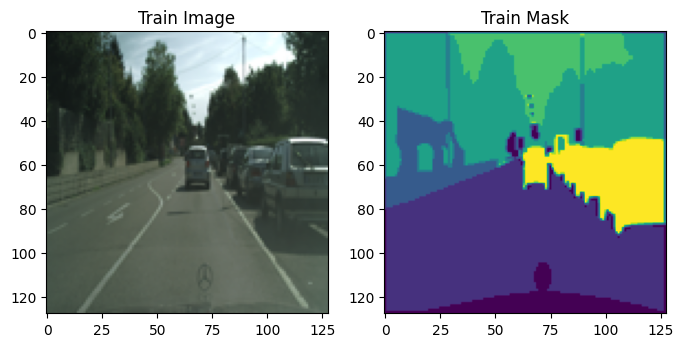

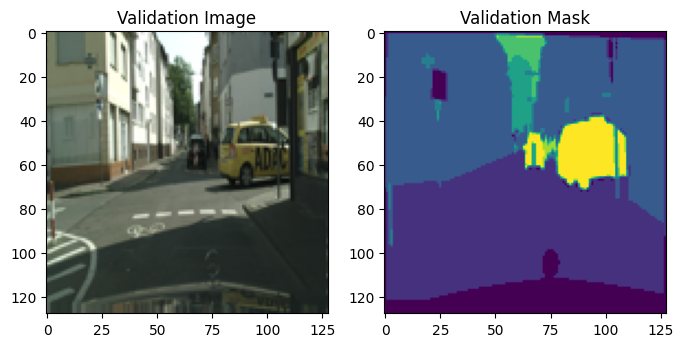

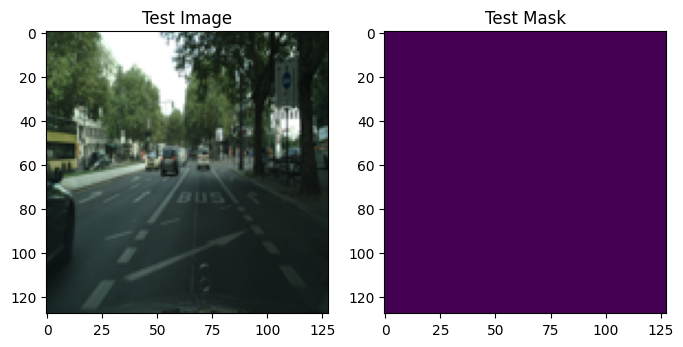

In [108]:
# train
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Train Image')
plt.imshow(train_images[0])
plt.subplot(1, 2, 2)
plt.title('Train Mask')
plt.imshow(remapped_train_masks[0])
plt.show()

# val
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Validation Image')
plt.imshow(val_images[0])
plt.subplot(1, 2, 2)
plt.title('Validation Mask')
plt.imshow(remapped_val_masks[0])
plt.show()

# test
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Test Image')
plt.imshow(test_images[0])
plt.subplot(1, 2, 2)
plt.title('Test Mask')
plt.imshow(remapped_test_masks[0])
plt.show()

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # bridge

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # decoder 
    
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # output layer
    outputs = Conv2D(8, 1, activation='softmax')(conv5)

    # créer le modèle
    model = Model(inputs=inputs, outputs=outputs)
    return model

# créer une instance du modèle U-Net
model = unet()

# compiler le modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,863,304 (7.11 MB)

 Trainable params: 1,863,304 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000 # nb d'éléments à garder en mémoire tampon lors du shuffle
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_images)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_images, remapped_train_masks, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=(val_images, remapped_val_masks),
                          callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 129s 38s/step - accuracy: 0.2409 - loss: 2.0142 - val_accuracy: 0.3924 - val_loss: 1.9965
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3924 - val_loss: 1.9965
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 102s 35s/step - accuracy: 0.3752 - loss: 1.8545 - val_accuracy: 0.3003 - val_loss: 1.8026
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3003 - val_loss: 1.8026
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 99s 34s/step - accuracy: 0.3414 - loss: 1.7916 - val_accuracy: 0.3924 - val_loss: 1.7418


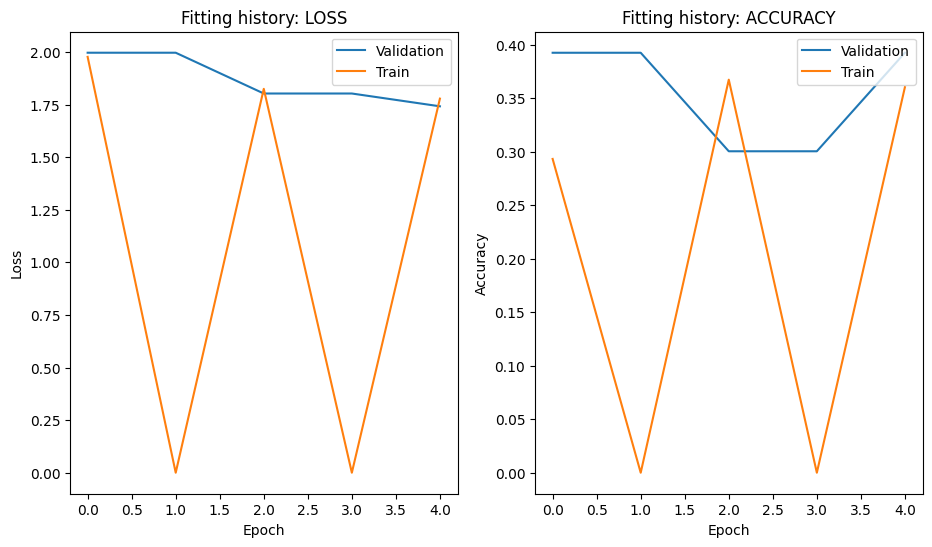

In [91]:
plt.figure(figsize=(11,6))

plt.subplot(1,2,1)
plt.plot(model_history.history['val_loss'])
plt.plot(model_history.history['loss'])
plt.title("Fitting history: LOSS")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(model_history.history['val_accuracy'])
plt.plot(model_history.history['accuracy'])
plt.title("Fitting history: ACCURACY")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.show()

In [97]:
# prédictions
pred_masks = model.predict(val_images)

# convertir les prédictions en masques de classe (chaque pixel prend la valeur de la classe avec la probabilité la plus élevée)
pred_masks = np.argmax(pred_masks, axis=-1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [106]:
print(pred_masks[6].min(), pred_masks[6].max())

1 2


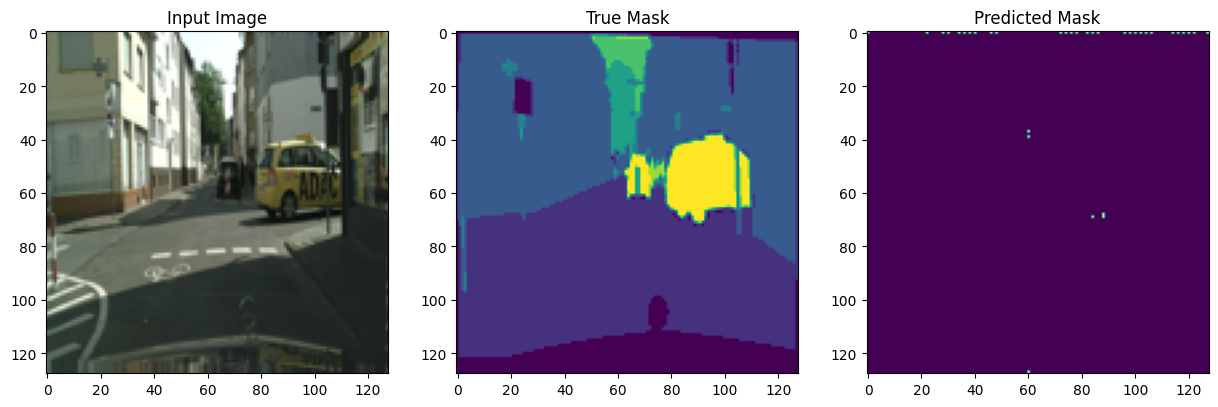

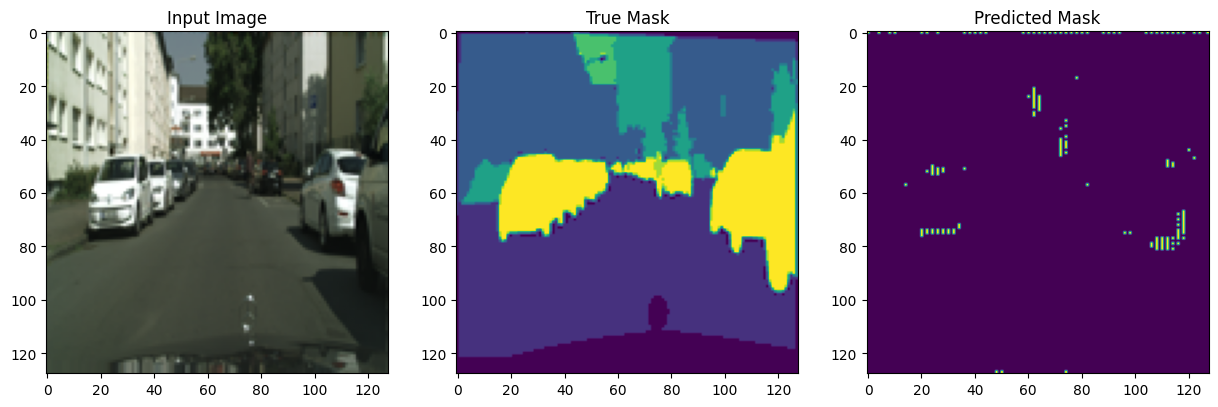

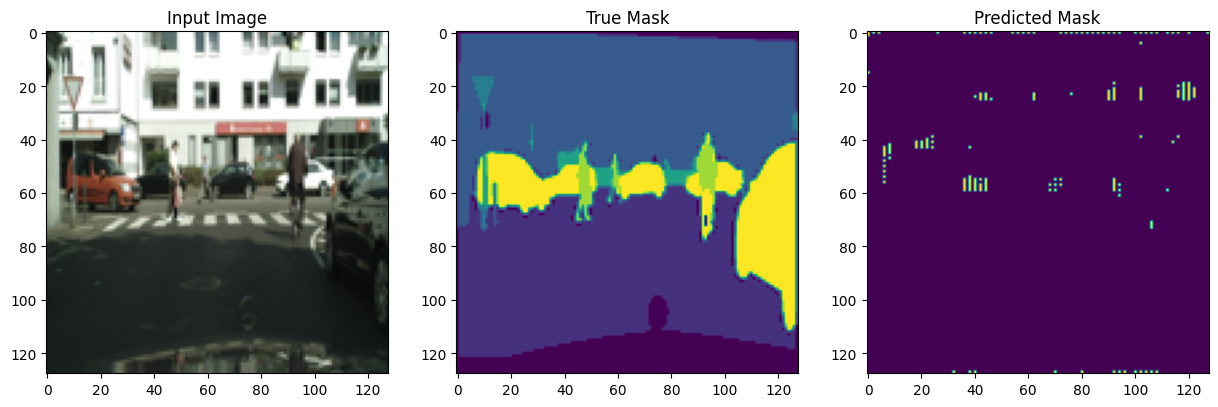

In [98]:
# visu
num_examples = 3
for i in range(num_examples):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(val_images[i])
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(remapped_val_masks[i])
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i])
    plt.title('Predicted Mask')

    plt.show()

Il semble que les masks test de berlin soient entièrement noirs, j'ai donc utilisé les val pour visualiser qqch.

In [109]:
def iou_metric(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls)
        union = np.logical_or(y_true == cls, y_pred == cls)
        if np.sum(union) == 0:
            iou_score = float('nan')  # évite la division par zéro
        else:
            iou_score = np.sum(intersection) / np.sum(union)
        ious.append(iou_score)
    return ious

In [114]:
# IoU pour chaque classe
num_classes = 8
ious = [] # ious pour chaque classe pour chaque paire de masques
for true_mask, pred_mask in zip(remapped_val_masks, pred_masks):
    ious.append(iou_metric(true_mask, pred_mask, num_classes))

In [115]:
# IoU moyen
mean_iou_per_class = np.mean(ious, axis=0)
mean_iou = np.mean(mean_iou_per_class)

In [120]:
mean_iou.round(2)

nan

In [117]:
mean_iou_per_class.round(2)

array([0.  , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  ,  nan])